## Imports

In [1]:
# note: must run in virtual environment
import os
import sys
venv_path = os.environ['VIRTUAL_ENV']
sys.path.append(os.path.join(os.environ['VIRTUAL_ENV'], "lib\site-packages"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
%matplotlib inline

## Consts

In [3]:
PROVIDER_AND_ID = "provider_and_id"
CITY = "accident_yishuv_name"
LAT = "latitude"
LONG = "longitude"
X = "x"
Y = "y"

## Load data

In [4]:
csv_path = "involved_markers_hebrew.csv"
data = pd.read_csv(csv_path)

c:\users\asya\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (36,38,40,44,91,93,130,144,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# get only relevant data
filtered = data[[PROVIDER_AND_ID, CITY, LAT, LONG, X, Y]]

## Find outliers by zscore

In [6]:
def get_outliers_by_z_scores(data, zscore_thresh):
    res = []
    for city, rows in data.groupby(CITY):
        coords = rows[[X, Y]]
        # calculate zscores for each column
        zscores = stats.zscore(coords, axis = 0)
        zscores = np.nan_to_num(zscores)
        zscores = np.abs(zscores)
        # get indices to outliers
        outliers = np.argwhere(zscores > zscore_thresh)
        outlier_rows = np.unique(outliers[:,0])
        if len(outliers) > 0:
            outlier_rows = rows.iloc[outlier_rows]
            res.append(outlier_rows[[PROVIDER_AND_ID, CITY, LAT, LONG]])
    return pd.concat(res)

## Visualize effect of different thresholds

C:\Users\Asya\PycharmProjects\sadna\anyway_venv\lib\site-packages\scipy\stats\stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


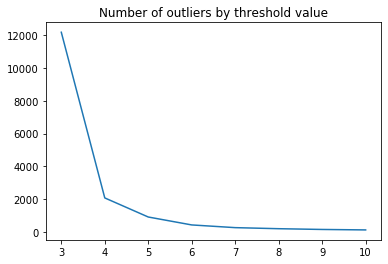

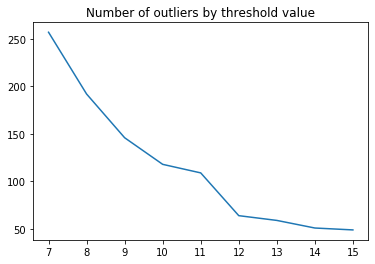

In [7]:
def plot_outliers_by_thresh(low, high):
    threshs = range(low, high+1)
    num_outliers = []
    for i in threshs:
        outliers = get_outliers_by_z_scores(filtered, i)
        num_outliers.append(len(outliers))
    plt.title("Number of outliers by threshold value")
    plt.plot(threshs, num_outliers)
    plt.show()
        
plot_outliers_by_thresh(3,10)
plot_outliers_by_thresh(7,15)

## Pick threshold and save output

In [8]:
ZSCORE_THRESH = 7

outliers = get_outliers_by_z_scores(filtered, ZSCORE_THRESH)
outliers.to_csv("outlier_points.csv", header=True, index=False, encoding='utf-8')